In [ ]:
def explore():
    # This Python 3 environment comes with many helpful analytics libraries installed
    # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
    # For example, here's several helpful packages to load
    
    import numpy as np # linear algebra
    import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
    from pathlib import Path
    
    # Input data files are available in the read-only "../input/" directory
    # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
    
    import os
    sortme = []
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            full_path = Path(dirname)/filename
            sortme.append(str(full_path))
            '''if full_path.suffix.lower().strip('.') in ['py', 'yaml', 'csv', 'bat'] or full_path.name == 'classes.txt':
                prefix = '/kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/'
                print(f'## [{str(full_path).removeprefix(prefix)}] ##')
                print(full_path.read_text())'''
            
    sortme.sort()
    for path in sortme:
        print(path)
    # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
    # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#explore()

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import v2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

import PIL

from tqdm import tqdm

In [146]:
## Device agnostic code and set the image size to use
IMAGE_SIZE_SQUARE = 512

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
print(f"Default device set to --> {device}")

Default device set to --> cuda


## Set root directories for each dataset

In [4]:
root_data_dir = Path('/kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/')
train_data_dir, eval_data_dir, test_data_dir = (root_data_dir / x for x in ['train', 'val', 'test'])
train_data_dir, eval_data_dir, test_data_dir

(PosixPath('/kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/train'),
 PosixPath('/kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/val'),
 PosixPath('/kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/test'))

## Check for corrupted images

In [5]:
ok = 0
errors = []
image_extensions = {}
for data_dir in [train_data_dir, eval_data_dir, test_data_dir]:
    dataset_name = data_dir.stem
    image_extensions[dataset_name] = set()
    for image_path in tqdm(list((data_dir / 'images').iterdir()), desc=dataset_name):
        if image_path.suffix.lower() not in {'.png', '.jpg', '.jpeg'}:
            continue
        try:
            # assume the image to not be corrupted if pillow can load it
            PIL.Image.open(image_path).load()
            ok += 1
        except Exception as e:
            errors.append((image_path, e))
for image_path, e in errors:
    print(image_path)
    print(e)
    print()
print(f'Images loaded successfuly: {ok}. Images that couldn\'t be loaded: {len(errors)}.')

test: 100%|██████████| 165/165 [00:11<00:00, 14.98it/s]

Images loaded successfuly: 664. Images that couldn't be loaded: 0.


In [6]:
# these functions don't care if the input is relative or absolute.
# if inputs are absolute, return values are absolute and
# if inputs are relative, return values are relative

def yolo_to_xy(x_center, y_center, w, h):
    xmin = x_center - w/2
    xmax = x_center + w/2
    ymin = y_center - h/2
    ymax = y_center + h/2
    
    return xmin, ymin, xmax, ymax

def xy_to_yolo(x1, y1, x2, y2):
    xmin = min(x1, x2)
    xmax = max(x1, x2)
    ymin = min(y1, y2)
    ymax = max(y1, y2)
    
    width = xmax - xmin
    height = ymax - ymin
    x_center = (xmin + xmax) / 2
    y_center = (ymin + ymax) / 2


    return (
        x_center,
        y_center,
        width,
        height
    )


#0 0.4231770833333333 0.4324074074074074 0.2140625 0.46296296296296297

# Since the function keeps everything within the same floating range, there~s gonna be some lost information 
x1, y1, x2, y2 = yolo_to_xy(0.4231770833333333, 0.4324074074074074, 0.2140625, 0.46296296296296297)
xy_to_yolo(x1, y1, x2, y2)

(0.4231770833333333,
 0.4324074074074074,
 0.21406249999999993,
 0.4629629629629629)

In [7]:
class CheeriosDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform_image=None, transform_image_bbox=None, target_transform=None):
        self.root_dir = Path(root_dir)
        self.image_dir = self.root_dir / 'images'
        self.label_dir = self.root_dir / 'labels'
        self.transform_image = transform_image
        self.transform_image_bbox = transform_image_bbox
        self.target_transform = target_transform
        self.image_file_paths = []
        self.data_pairs = []
        
        for image_path in self.image_dir.iterdir():
            if image_path.suffix.lower() not in {'.jpeg', '.jpg', '.png'}:
                continue  # ignore if it's not an image
            self.image_file_paths.append(image_path)
            
        self.image_file_paths.sort()


        # assign the corresponding label for each image, storing the assignments in data_pairs
        for image_path in self.image_file_paths:
            label_path = self.label_dir / image_path.with_suffix('.txt').name
            #print(label_path)
            text_content = label_path.read_text().strip() if label_path.is_file() else None
            all_labels = []
            if text_content:
                for line in text_content.splitlines():
                    _, center_x, center_y, width, height = map(float, line.strip().split())
                    all_labels.append([1, center_x, center_y, width, height])
                self.data_pairs.append((image_path, all_labels))
            else:
                self.data_pairs.append((image_path, []))

        # initialize cache to prevent loading the same file more than once
        self.image_cache = [None] * len(self.image_file_paths)

    def __len__(self):
        return len(self.data_pairs)

    def __getitem__(self, idx):
        image_path, label = self.data_pairs[idx]
        if self.image_cache[idx] is None:
            pilimg = PIL.Image.open(image_path).convert('RGB')
            image_tensor = v2.functional.pil_to_tensor(pilimg).type(torch.uint8)
            image = torchvision.tv_tensors.Image(image_tensor)
            self.image_cache[idx] = image
        else:
            image = self.image_cache[idx]

        orig_height, orig_width = image.shape[1:]

        # create a list of lists (for some reason using a tensor here throws a mysterious exception)
        # only create in case label is existent
        image = image.cpu()
        retlabel = torch.tensor([]) # for in case there is no label, it will just return an empty tensor
        if label != []:
            bboxes = []
            for label_line in label:
                _, cx_norm, cy_norm, w_norm, h_norm = label_line
                bboxes.append(
                    # convert everything to xyxy
                    list(yolo_to_xy(
                        (cx_norm * orig_width),
                        (cy_norm * orig_height),
                        (w_norm * orig_width),
                        (h_norm * orig_height)
                    ))
                )
    
            bboxes_tv = torchvision.tv_tensors.BoundingBoxes(
                bboxes,
                format='XYXY',
                canvas_size=image.shape[-2:]
            )

            # for cpu only operations with transform
            
            if self.transform_image_bbox:
                if bboxes:
                    image, bboxes_tv = self.transform_image_bbox(image, bboxes_tv)
                else:
                    image = self.transform_image_bbox(image)
            
            if self.transform_image:
                image = self.transform_image(image)
    
            if len(bboxes_tv) > 0:
                # convert the silly list of lists back into a tensor
                retlabel = torch.tensor([list(xy_to_yolo(*label_line)) for label_line in bboxes_tv])
                
            else:
                retlabel = torch.zeros((0, 4), dtype=torch.float32)
    
            if self.target_transform:
                retlabel = self.target_transform(retlabel)
        else:
            if self.transform_image_bbox:
                image = self.transform_image_bbox(image)
                    
            if self.transform_image:
                image = self.transform_image(image)
                
        image = image.cpu()
        return image, retlabel


## Basic EDA: check how many positives and negatives

In [8]:
from collections import Counter
train_dataset = CheeriosDataset(train_data_dir)
eval_dataset = CheeriosDataset(eval_data_dir)
test_dataset = CheeriosDataset(test_data_dir)
union = train_dataset.data_pairs #+ eval_dataset.data_pairs

c = Counter()
for _, label in union:  # avoid loading the images
    c[len(label)] += 1
print(f"Images with/wihout a cheerio box {c}")

Images with/wihout a cheerio box Counter({1: 424, 0: 7})


In [9]:
# transforms that only apply to the pixels themselves
transform_image = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    v2.GaussianBlur(kernel_size=5, sigma=(0.001, 2.0)),
    v2.GaussianNoise(sigma=0.05),
    v2.ToDtype(torch.uint8, scale=True),
    v2.RandomChoice([
        v2.ColorJitter(
            brightness=0.8,
            contrast=0.8,
            saturation=0.8,
            hue=0.2
        ),
        v2.RandomPosterize(bits=3),
        v2.RandomSolarize(threshold=0.5),
    ]),
    v2.JPEG(quality=(50, 100)),
])

# transforms that apply to the pixels and/or the bounding boxes
transform_image_bbox =  v2.Compose([
    v2.Resize((IMAGE_SIZE_SQUARE, IMAGE_SIZE_SQUARE)),
    v2.RandomHorizontalFlip(0.2),
    v2.RandomVerticalFlip(0.2),
    v2.RandomAffine(
        degrees=(-60, 60),
        translate=(0.3, 0.3),
        scale=(0.5, 1.5),
        shear=(-30, 30)
    ),

    # using SanitizeBoundingBoxes here is scary because we only have one bbox per datapoint
])


In [10]:
train_dataset = CheeriosDataset(train_data_dir, transform_image, transform_image_bbox)
train_dataset_no_transforms = CheeriosDataset(train_data_dir, None, None)
eval_dataset = CheeriosDataset(eval_data_dir, transform_image, transform_image_bbox)

## Visualize a random image + bbox after being transformed

tensor([[[132.6243, 236.3583, 175.0126, 273.9453]]], device='cuda:0')
tensor([132.6243, 236.3583, 175.0126, 273.9453], device='cuda:0')


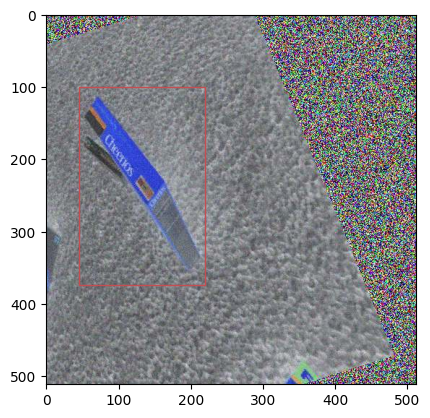

In [148]:
from matplotlib.patches import Rectangle

dl = torch.utils.data.DataLoader(train_dataset, shuffle=1, generator=torch.Generator(device=device))

image, label = next(iter(dl))

plt.imshow(torch.permute(image.squeeze(), (1, 2, 0)))
ax = plt.gca()
print(label)
for bbox in label[0]:
    print(bbox)
    # to make things maybe simpler, `label` doesn't contain the class,
    # it's just the bounding box in centerx, centery, width, height format.
    # IMPORTANT: the coordinates of the bounding box are ABSOLUTE. to convert to relative
    # do `bbox = bbox/IMAGE_SIZE_SQUARE`
    bbox = bbox.cpu()
    ax.add_patch(Rectangle((
        bbox[0] - bbox[2]/2,
        bbox[1] - bbox[3]/2
    ), bbox[2], bbox[3],linewidth=1,edgecolor='r',facecolor='none'))

(0.31614583333333335, 0.20092592592592592, 0.5302083333333333, 0.6638888888888889)
161.86666666666667


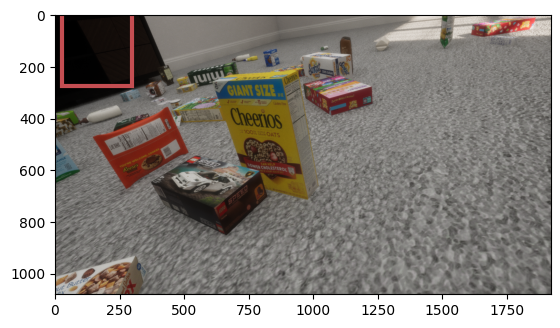

In [182]:




def plot_bbox(img_path: str, bbox):
    print(bbox)
    bbox = [bbox[i]*512 for i in range(len(bbox))]
    ax = plt.gca()
    ax.imshow(PIL.Image.open(img_path))

    print(bbox[0])
    ax.add_patch(Rectangle((
        bbox[0] - bbox[2]/2,
        bbox[1] - bbox[3]/2
    ), bbox[2], bbox[3],linewidth=3,edgecolor='r',facecolor='none'))
    plt.show()

plot_bbox("/kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/val/images/000000003.png", bbox=yolo_to_xy(0.4231770833333333, 0.4324074074074074, 0.2140625, 0.46296296296296297))

# Visualize an image both with and without the transformation

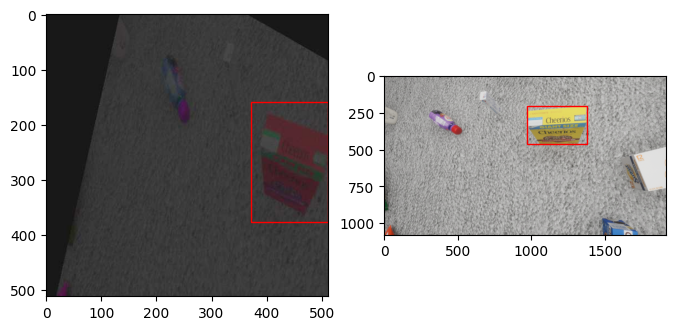

In [12]:
from matplotlib.patches import Rectangle

dataloaders = [torch.utils.data.DataLoader(train_dataset, shuffle=0, generator=torch.Generator(device=device)), torch.utils.data.DataLoader(train_dataset_no_transforms, shuffle=0, generator=torch.Generator(device=device))]

labels = []
fig, axis = plt.subplots(1, 2, figsize=(8, 16))
for ax_idx in range(2):
    image, label = next(iter(dataloaders[ax_idx]))
    labels.append(label)
    axis[ax_idx].imshow(torch.permute(image.squeeze(), (1, 2, 0)))
ax = plt.gca()
for idx, label in enumerate(labels):
    for bbox in label[0]:
        # to make things maybe simpler, `label` doesn't contain the class,
        # it's just the bounding box in centerx, centery, width, height format.
        # IMPORTANT: the coordinates of the bounding box are ABSOLUTE. to convert to relative
        # do `bbox = bbox/IMAGE_SIZE_SQUARE`
        bbox = bbox.cpu()
        axis[idx].add_patch(Rectangle((
            bbox[0] - bbox[2]/2,
            bbox[1] - bbox[3]/2
        ), bbox[2], bbox[3],linewidth=1,edgecolor='r',facecolor='none'))

# Work with Yolo model

In [13]:
pip install git+https://github.com/ultralytics/ultralytics.git@main

  Cloning https://github.com/ultralytics/ultralytics.git (to revision main) to /tmp/pip-req-build-8byhhrji
  Running command git clone --filter=blob:none --quiet https://github.com/ultralytics/ultralytics.git /tmp/pip-req-build-8byhhrji
  Resolved https://github.com/ultralytics/ultralytics.git to commit 820e1165a2cb21f50a574b82b861ebca9728007c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ultralytics: filename=ultralytics-8.3.105-py3-none-any.whl size=972924 sha256=4654d694d9208afb3f4581087881882e9f4f545339649c6db955fe52098ff6a4
  Stored in directory: /tmp/pip-ephem-wheel-cache-pwgo2rwj/wheels/60/db/e5/6abbdd13b4e3d5e2fdcd87690cd8738f842eeb37142fdccb5b
Successfully built ultralytics
Note: you may need to restart the kernel to use updated packages.


In [14]:
from ultralytics import YOLO
import cv2

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [74]:
model = YOLO("yolov8n-seg.pt")

# Image test for segmentation


0: 640x448 1 person, 12.3ms
Speed: 3.1ms preprocess, 12.3ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 448)
[[[ 990 3450]
  [ 990 3499]
  [ 982 3507]
  [ 982 3523]
  [ 990 3531]
  [ 990 3555]
  [ 999 3564]
  [ 999 3580]
  [1007 3588]
  [1007 3636]
  [ 999 3645]
  [ 999 3669]
  [ 990 3677]
  [ 990 3685]
  [ 974 3701]
  [ 974 3709]
  [ 966 3717]
  [ 966 3726]
  [ 958 3734]
  [ 958 3742]
  [ 950 3750]
  [ 950 3782]
  [ 958 3790]
  [ 958 3798]
  [ 966 3807]
  [ 966 3855]
  [ 974 3863]
  [ 974 3928]
  [ 982 3936]
  [ 982 3985]
  [ 990 3993]
  [ 990 4001]
  [ 982 4009]
  [ 982 4033]
  [ 974 4041]
  [ 974 4050]
  [ 934 4090]
  [ 926 4090]
  [ 893 4122]
  [ 893 4171]
  [ 901 4179]
  [ 901 4244]
  [ 893 4252]
  [ 893 4260]
  [ 885 4268]
  [ 885 4284]
  [ 877 4293]
  [ 877 4317]
  [ 869 4325]
  [ 869 4341]
  [ 861 4349]
  [ 861 4374]
  [ 853 4382]
  [ 853 4406]
  [ 845 4414]
  [ 845 4438]
  [ 837 4446]
  [ 837 4463]
  [ 828 4471]
  [ 828 4487]
  [ 820 4495]
  [ 820 4527]
  [ 81

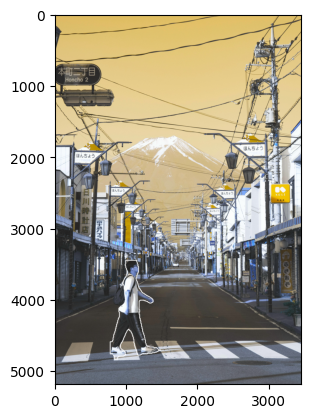

In [76]:
#image = train_dataset[0]
# For YOLO, image pixels must be between 0-1, so must divide by 255
# Might do it in the dataset itself later for pre-processing

image = cv2.imread("/kaggle/input/test-image/pexels-xenofan-696995602-31006027aaaaa.jpg")
preds = model.predict(image, conf=0.5)
for pred in preds:
    #print(pred.masks.xy)
    #print(pred.boxes)
    for mask in pred.masks.xy:
        box_coords = np.int32([mask])
        cv2.polylines(image, box_coords, isClosed=True, color=(255, 255, 255), thickness=10)
        print(box_coords)

plt.imshow(image)
plt.show()

In [17]:
!mkdir ./torch_modified_dataset

# Adding more data to dataset using pytorch

In [18]:
# redefining datasets for clarity
train_dataset = CheeriosDataset(train_data_dir, transform_image, transform_image_bbox)
test_dataset = CheeriosDataset(test_data_dir, transform_image, transform_image_bbox)
eval_dataset = CheeriosDataset(eval_data_dir, transform_image, transform_image_bbox)


# test has no labels since it's for submission
train_dataloader = DataLoader(train_dataset, shuffle=False, generator=torch.Generator(device=device))
test_dataloader = DataLoader(test_dataset, shuffle=False, generator=torch.Generator(device=device))
eval_dataloader = DataLoader(eval_dataset, shuffle=False, generator=torch.Generator(device=device))
dataloaders = {"train": train_dataloader, "val": eval_dataloader}

In [19]:
!mkdir -p /kaggle/working/torch_modified_dataset/data/train/images
!mkdir -p /kaggle/working/torch_modified_dataset/data/train/labels

!mkdir -p /kaggle/working/torch_modified_dataset/data/test/images
!mkdir -p /kaggle/working/torch_modified_dataset/data/test/labels

!mkdir -p /kaggle/working/torch_modified_dataset/data/val/images
!mkdir -p /kaggle/working/torch_modified_dataset/data/val/labels

!rsync -aP --exclude=data "/kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/"* /kaggle/working/torch_modified_dataset

sending incremental file list
classes.txt
             10 100%    0.00kB/s    0:00:00 (xfr#1, to-chk=9/10)
convert_preds_to_csv.py
          3,868 100%    1.23MB/s    0:00:00 (xfr#2, to-chk=8/10)
predict.py
          3,734 100%  729.30kB/s    0:00:00 (xfr#3, to-chk=7/10)
sample_submission.csv
         14,556 100%    1.74MB/s    0:00:00 (xfr#4, to-chk=6/10)
train.py
          5,647 100%  501.33kB/s    0:00:00 (xfr#5, to-chk=5/10)
yolo_params.yaml
            283 100%   19.74kB/s    0:00:00 (xfr#6, to-chk=4/10)
ENV_SETUP/
ENV_SETUP/create_env.bat
            334 100%   19.19kB/s    0:00:00 (xfr#7, to-chk=2/10)
ENV_SETUP/install_packages.bat
          1,059 100%   54.43kB/s    0:00:00 (xfr#8, to-chk=1/10)
ENV_SETUP/setup_env.bat
            245 100%   10.88kB/s    0:00:00 (xfr#9, to-chk=0/10)


In [20]:
torch_dataset_root_dir = "/kaggle/working/torch_modified_dataset"
for k, dl in dataloaders.items():
    print(f"{root_data_dir}/{k}")
    for idx, (image, label) in tqdm(enumerate(dl)):
        #PIL.Image.fromarray(image.squeeze().cpu().numpy()).save(f"./{k}_{idx}")
        torchvision.utils.save_image(image.squeeze()/255, f"{torch_dataset_root_dir}/data/{k}/images/{k}_{idx}.png")
        if label.nelement() != 0:
            # cat to add 0 for the class
            label = torch.cat([torch.tensor([0]), (label.squeeze()/IMAGE_SIZE_SQUARE)]).cpu().numpy().astype(np.double)
        else:
            if k != "test":
                label = label.squeeze().cpu().numpy()
        with open(f"/{torch_dataset_root_dir}/data/{k}/labels/{k}_{idx}.txt", "w") as f:
            f.write(" ".join(str(x) for x in label))
            f.close()

/kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/train


431it [01:47,  3.99it/s]


/kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/val


69it [00:17,  3.96it/s]


In [21]:
!cp -rf "/kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/train/images/"* /kaggle/working/torch_modified_dataset/data/train/images
!cp -rf "/kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/test/images/"* /kaggle/working/torch_modified_dataset/data/test/images
!cp -rf "/kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/val/images/"* /kaggle/working/torch_modified_dataset/data/val/images

!cp -rf "/kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/train/labels/"* /kaggle/working/torch_modified_dataset/data/train/labels
!cp -rf "/kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/val/labels/"* /kaggle/working/torch_modified_dataset/data/val/labels



# Edit yaml for yolo params

In [22]:
yaml_text = """
# Dataset paths

train: /kaggle/working/torch_modified_dataset/data/train/images/  # Path to training images

val: /kaggle/working/torch_modified_dataset/data/val/images/      # Path to validation images

test: /kaggle/working/torch_modified_dataset/data/train/images/    # Path to test images



# Class information

nc: 1                     # Number of classes

names: ['cheerios']       # Class names
"""

with open ("/kaggle/working/torch_modified_dataset/yolo_params.yaml", "w") as f:
    f.write(yaml_text)

# Reset default device for YOLO
- YOLO dataloaders don't use gpu by default (no cuda generators), thus they might throw out error while trying to use the dataloader

In [150]:
torch.set_default_device("cpu")

In [151]:
# get proper model
model = YOLO(model="yolov8n.pt")

In [31]:
# if this goes bad, dont change image size neither bbox, yolo can take care of it by itself
epochs = 10
model.train(
    data="/kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/yolo_params.yaml",
    epochs=epochs,
    lr0=0.0005,
    lrf=0.005,
    patience=int(epochs/20),
    save=True,
    batch=16,
    workers=12,
    imgsz=IMAGE_SIZE_SQUARE,
    device=device
)

# num of workers based on my own cpu

Ultralytics 8.3.105 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/yolo_params.yaml, epochs=10, time=None, patience=0, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=cuda, workers=12, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_tx

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7915676081f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1535, in _shutdown_workers
    if not self._shutdown:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_shutdown'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7915676081f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1535, in _shutdown_workers
    if not self._shutdown:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_shutdown'


Model summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
TensorBoard: Start with 'tensorboard --logdir runs/detect/train3', view at http://localhost:6006/
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:106: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  return func(*args, **kwargs)


AMP: checks passed ✅


train: Scanning /kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/train/labels... 431 images, 7 backgrounds, 0 corrupt: 100%|██████████| 431/431 [00:01<00:00, 319.55it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/val/labels... 69 images, 1 backgrounds, 0 corrupt: 100%|██████████| 69/69 [00:00<00:00, 138.04it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/val is not writeable, cache not saved.


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 4 dataloader workers
Logging results to runs/detect/train3
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/27 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:106: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  return func(*args, **kwargs)
       1/10      4.57G     0.7092      2.572     0.8843         13        512: 100%|██████████| 27/27 [00:16<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib

                   all         69         68    0.00329          1      0.748      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/27 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:106: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  return func(*args, **kwargs)
       2/10      4.57G     0.7262      1.524     0.9018         15        512: 100%|██████████| 27/27 [00:10<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib

                   all         69         68          1      0.289      0.788      0.602

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/27 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:106: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  return func(*args, **kwargs)
       3/10      4.57G     0.7743       1.41     0.9104         15        512: 100%|██████████| 27/27 [00:13<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib

                   all         69         68      0.867      0.767      0.881      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/27 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:106: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  return func(*args, **kwargs)
       4/10      4.57G       0.72      1.236     0.9121         15        512: 100%|██████████| 27/27 [00:10<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib

                   all         69         68      0.875      0.897      0.929      0.726

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/27 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:106: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  return func(*args, **kwargs)
       5/10      4.57G     0.7036       1.06     0.9037         15        512: 100%|██████████| 27/27 [00:12<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib

                   all         69         68      0.978      0.882      0.968      0.803

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/27 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:106: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  return func(*args, **kwargs)
       6/10      4.57G     0.6461     0.9496     0.8896         15        512: 100%|██████████| 27/27 [00:11<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib

                   all         69         68      0.969       0.92      0.971      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/27 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:106: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  return func(*args, **kwargs)
       7/10      4.57G     0.6255     0.8647     0.8867         14        512: 100%|██████████| 27/27 [00:12<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib

                   all         69         68      0.997      0.853      0.925       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/27 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:106: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  return func(*args, **kwargs)
       8/10      4.57G     0.5493     0.7853     0.8503         14        512: 100%|██████████| 27/27 [00:11<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib

                   all         69         68      0.981      0.882       0.98      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/27 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:106: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  return func(*args, **kwargs)
       9/10      4.57G     0.5264     0.6947     0.8447         14        512: 100%|██████████| 27/27 [00:10<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib

                   all         69         68      0.941      0.971      0.988      0.883

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/27 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:106: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  return func(*args, **kwargs)
      10/10      4.57G     0.4908     0.6618     0.8394         14        512: 100%|██████████| 27/27 [00:12<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib

                   all         69         68      0.996      0.926      0.988      0.899



10 epochs completed in 0.041 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.2MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.105 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:106: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  return func(*args, **kwargs)


Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]


                   all         69         68      0.996      0.926      0.988      0.899


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 1.5ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7912f7a01210>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Test on a test image

In [32]:
model.names

{0: 'cheerios'}

# Small sanity check for the model
- check if it can pred the bbox for any of the images; if cannot, must train in a different way (broken shit)

In [66]:
# This is based on segmentation model
# Doesn't seems like bounding box models use mask. instead they have their own boxes property

import glob
path = glob.glob("/kaggle/working/torch_modified_dataset/data/test/images/*")
def pred_on_image(model, idx):
    image = cv2.imread(path[idx])
    preds = model.predict(image, conf=0.5, verbose=False)
    #print(preds)
    for pred in preds:
        #print(pred.masks.xy)
        #print(pred.boxes)
        if pred.masks:
            for mask in pred.masks.xy:
                box_coords = np.int32([mask])
                cv2.polylines(image, box_coords, isClosed=True, color=(255, 255, 255), thickness=10)
            plt.imshow(image)
            plt.show()
            return 1
    return 0
    
    
found = 0
i = 0
while i < len(path):
    if pred_on_image(model=model, idx=i) == 1:
        found += 1
        print(f"found --> {found}")
        break
    i += 1
    #print(i)


print(f"found --> {found}")


WARNING ⚠️ 'source' is missing. Using 'source=/usr/local/lib/python3.10/dist-packages/ultralytics/assets'.
found --> 0


[     357.84     0.04184      1073.1      553.26     0.61509          58]
[0.6169270833333333, 0.6472222222222223, 0.11822916666666666, 0.12962962962962962]


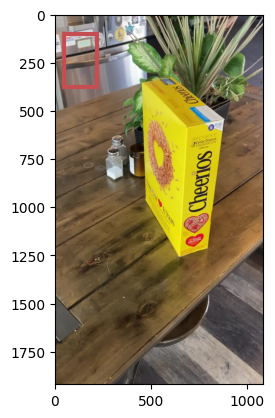

In [156]:
def pred_on_image(model, idx):
    image = cv2.imread(path[idx])
    preds = model.predict(image, conf=0.5, verbose=False)
    for pred in preds:
        bbox = pred.boxes.data.cpu().squeeze().numpy()
        print(bbox)
        
        plot_bbox(path[idx], [0.6169270833333333, 0.6472222222222223, 0.11822916666666666, 0.12962962962962962])
        #cv2.polylines(image, bbox, isClosed=True, color=(255, 0, 0))

pred_on_image(model=model, idx=2)